**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

**Notebook**: Written by Prof. Keith Chugg.  `plotDecBoundaries` written by former TA Arindam Jati.

# Nearest Means Classifier
This sheet shows how to use the helper function `plotDecBoundaries` that is provided for homework assignment 1.  This allows you to visualize the decision boundaries with a nearest mean classifier.  

First, let's import the the helper function from the `utils` directory.  Note that this assumes that the file `plotDecBoundaries.py` is in the directory `utils` which is a subdirectory in the directory containing this file.  Another approach is to put the `utils` directory someplace else on your hard-drive and include the parent directory in your `PYTHONPATH`.  The advantage of this second approach is that you can use the `utils` directory in many different projects that are not all in the same directory without duplicating the `utils` directory.  For more information: [setting your Python path](https://www.techwalla.com/articles/how-to-set-your-python-path)

In [65]:
from utils.plotDecBoundaries import plotDecBoundaries

import numpy as np 
import matplotlib.pyplot as plt

Now let's generate some data to pass to the `plotDecBoundaries` helper function.  We need to generate data from 2 classes.  Let's generate data from a Gaussian distribution with a given mean vector and variance.  This assumes the $x_1$ and $x_2$ coordinates are independent and have the same variance.  The  `plotDecBoundaries` helper function expects to see this data passed as a single array of 2D points with an associated labels array. The labels are indexed starting at 1 -- i.e., for a two-class problem the labels are either 1 or 2.

In [66]:
m1 =  np.asarray([5, 5])
sigma1 = 2

m2 = np.asarray([5, -5])
sigma2 = 2

N1 = 2000
N2 = 2000
N = N1 + N2

x = np.zeros((N, 2))
x[:N1] = np.random.normal(0, sigma1, (N1, 2)) + m1
x[N1:] = np.random.normal(0, sigma2, (N2, 2)) + m2

labels = np.ones(N)
labels[N1:] += 1

sample_means = np.zeros((2,2))
sample_means[0] = np.mean(x[:N1], axis=0)
sample_means[1] = np.mean(x[N1:], axis=0)

Let's check to see what the sample means are compared to the means (ensemble average):.  You should run this cell mutilple time sto see that the sample means change with data realizations.

In [67]:
print(f'{N} total data points.  {N1} in class 1 and {N2} in class 2\n')

print(f'The mean in the generating pdf for class 1 is: {m1}')
print(f'The sample mean for class 1 data is: {sample_means[0]}\n')

print(f'The mean in the generating pdf for class 2 is: {m2}')
print(f'The sample mean for class 2 data is: {sample_means[1]}')

4000 total data points.  2000 in class 1 and 2000 in class 2

The mean in the generating pdf for class 1 is: [5 5]
The sample mean for class 1 data is: [5.0398246  4.98300293]

The mean in the generating pdf for class 2 is: [ 5 -5]
The sample mean for class 2 data is: [ 4.99323087 -5.00911205]


Now let's use the helper function provided.

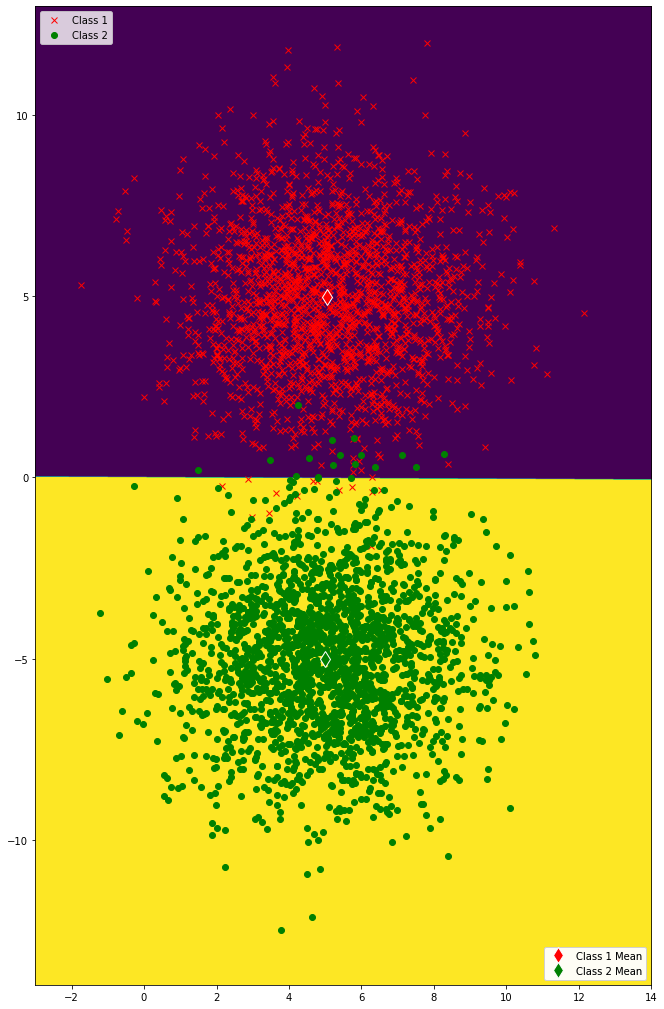

In [68]:
plotDecBoundaries(x, labels, sample_means, fsize=(18,18))

Let's write a function to make the data generation a little more compact.  It is often useful to generate Python code is a "scripting" style as above, which is simple to follow and debug, and then create a function/class and consolidate some of the code.

In [69]:
def generate_white_gaussian_data(means, sigmas, Ns):
    N = Ns[0] + Ns[1]
    x = np.zeros((N, 2))
    x[:Ns[0]] = np.random.normal(0, sigmas[0], (Ns[0], 2)) + means[0]
    x[Ns[0]:] = np.random.normal(0, sigmas[1], (Ns[1], 2)) + means[1]

    labels = np.ones(Ns[0] + Ns[1])
    labels[Ns[0]:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:Ns[0]], axis=0)
    sample_means[1] = np.mean(x[Ns[0]:], axis=0)

    return x, labels, sample_means

And now let's use this function to repeat the above...

In [70]:
means = np.asarray([ [5,5], [5, -5]])
sigmas = np.asarray([0.5, 0.5])
Ns = np.asarray([2000, 2000])

x, labels, sample_means = generate_white_gaussian_data(means, sigmas, Ns)

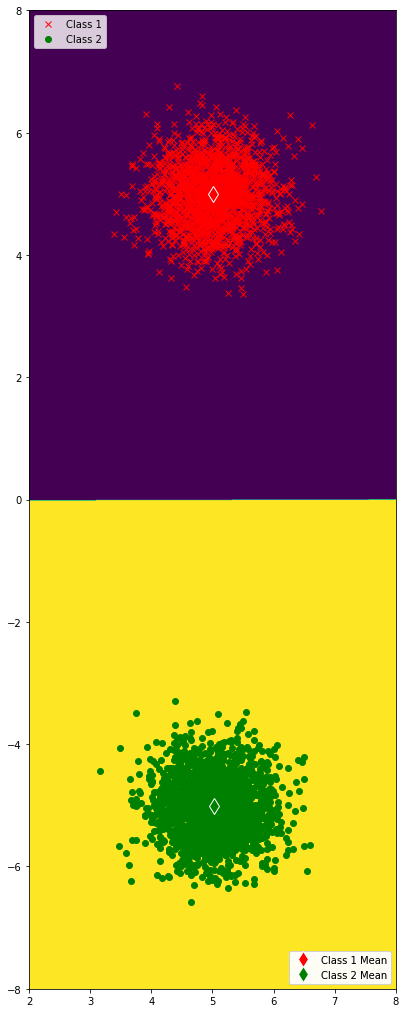

In [71]:
plotDecBoundaries(x, labels, sample_means, fsize=(18,18))

**Suggestion:** Experiment with the above code.  What happens if there are very few data points?  What if there are very many data points?  What properties of the generated data determine the misclassification rate?

## More complex examples

The nearest means classifier makes reasonable intuitive sense.  How can we generate some data that will cause problems for this classifier?

One possibilitiy:
- If the "cluster" of data points are not symmetrically distributed around the sample mean

This could occur with Guassian data if the $x_1$ and $x_2$ coordinates are correlated.  In this case, the cloud of data will take on a elliptical shape with major and minor access rotated relative to the $(x_1, x_2)$ axes.  The shape of the elliptical cloud and the degree of rotation are determined by the covariance matrix of ${\bf x}$ -- i.e., the variances of $x_1$ and $x_2$ along with the covariance of $x_1$, $x_2$. 

Another way that the data cloud could be nonsymmetric around the sample mean is if the underlying distribution is not Guassian (or circularly symmetric around the mean).  

In the function below, we generate data that comes from a 'normal', 'exponential', or 'uniform' distribution.  This data is first generated as independent and standardized in $x_1$ and $x_2$, then it is "colored" by multiplying by a matrix ${\bf H}$.  This coloring makes the resulting random vector non uncorrelated and equal variance in the $x_1$, $x_2$ plane.  Instead, it has a directional preference.  In one direction the variance is larger and, in the orthogonal direction, the variance is smaller.  

In the following function, the user specifies the mean vectors, the variance it the rotated coordinate system, the angle of rotation for the coordinate system, and the distribution type. 

In [78]:
def generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal'):
    """
    means: shape (2, 2), means[0] is the 2 x 1 mean vector for class 1 data generation
    lambdas: shape (2, 2), lambdas[0] are the 2 eigenvalues of the covariance matrix for generatinge data for class 1
    Ns: [N1, N2] the number of samples to be generated for each of teh two classes.
    distribution: in {normal, exponential, uniform} sets the distribution to generate data for both classes.
    """
    N1 = Ns[0]
    N2 =  Ns[1]
    N = N1 + N2
    x = np.zeros((N, 2))
    assert distribution in {'normal', 'exponential', 'uniform'}, f'The {distribution} is not supported, only normal, exponential, uniform distributions are supported.'
    assert np.min(lambdas) > 0, f'lambda all have to be > 0 as they are variaces of the random vector projected onto the eigen-vectors.  You passed lambdas = {lambdas}'
    if distribution == 'normal':
        x[:N1] = np.random.normal(0, 1, (N1, 2))
        x[N1:] = np.random.normal(0, 1, (N2, 2))
    elif distribution == 'exponential':
        ## np.random.exponential(1) generates realizations from a unit variance, mean 1
        x[:N1] = np.random.exponential(1, (N1, 2)) - 1
        x[N1:] = np.random.exponential(1, (N2, 2)) - 1
    elif distribution == 'uniform':
        ## variance of uniform on (a,b) is (b-a)^2 / 12
        a = np.sqrt(3)
        x[:N1] = np.random.uniform(-a, a, (N1, 2))
        x[N1:] = np.random.uniform(-a, a, (N1, 2))

    def compute_coloring_matrix(theta, lams):
        E = np.asarray([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)] ])
        Lambda_root = np.sqrt( np.asarray([ [lams[0], 0], [0, lams[1]] ]) )
        H = E @ Lambda_root
        K = H @ H.T
        return H, K

    H1, K1 = compute_coloring_matrix(thetas[0], lambdas[0])
    H2, K2 = compute_coloring_matrix(thetas[1], lambdas[1])

    x[:N1] = x[:N1] @ H1.T + means[0]
    x[N1:] = x[N1:] @ H2.T + means[1]

    labels = np.ones(N)
    labels[N1:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:N1], axis=0)
    sample_means[1] = np.mean(x[N1:], axis=0)

    print(f'Data generated under the {distribution} distribution')
    Ks = [K1, K2]
    Hs = [H1, H2]

    for i in range(2):
        print(f'The mean in the generating pdf for class {i + 1} is: {means[i]}')
        print(f'The sample mean for class {i + 1}  data is: {sample_means[i]}\n')

        print(f'The coloring matrix class {i + 1}  data is:\n {Hs[i]}')
        print(f'The covariance matrix class {i + 1}  data is:\n {Ks[i]}\n\n')

    return x, labels, sample_means

Let's demo this with Gaussina data.  The data under class 1 is rotated $\pi / 6$ and has variance 1 in the first coordinate of the rotated coordinate system and variance 4 in the other.  The data under class 2 is rotated $\pi / 3$ and has variance 5 in the first coordinate of the rotated coordinate system and variance 1 in the other.  

Data generated under the normal distribution
The mean in the generating pdf for class 1 is: [5 5]
The sample mean for class 1  data is: [5.02370567 4.98009822]

The coloring matrix class 1  data is:
 [[ 0.8660254  -1.        ]
 [ 0.5         1.73205081]]
The covariance matrix class 1  data is:
 [[ 1.75       -1.29903811]
 [-1.29903811  3.25      ]]


The mean in the generating pdf for class 2 is: [-5 -5]
The sample mean for class 2  data is: [-5.00268858 -4.99417786]

The coloring matrix class 2  data is:
 [[ 1.11803399 -0.8660254 ]
 [ 1.93649167  0.5       ]]
The covariance matrix class 2  data is:
 [[2.         1.73205081]
 [1.73205081 4.        ]]




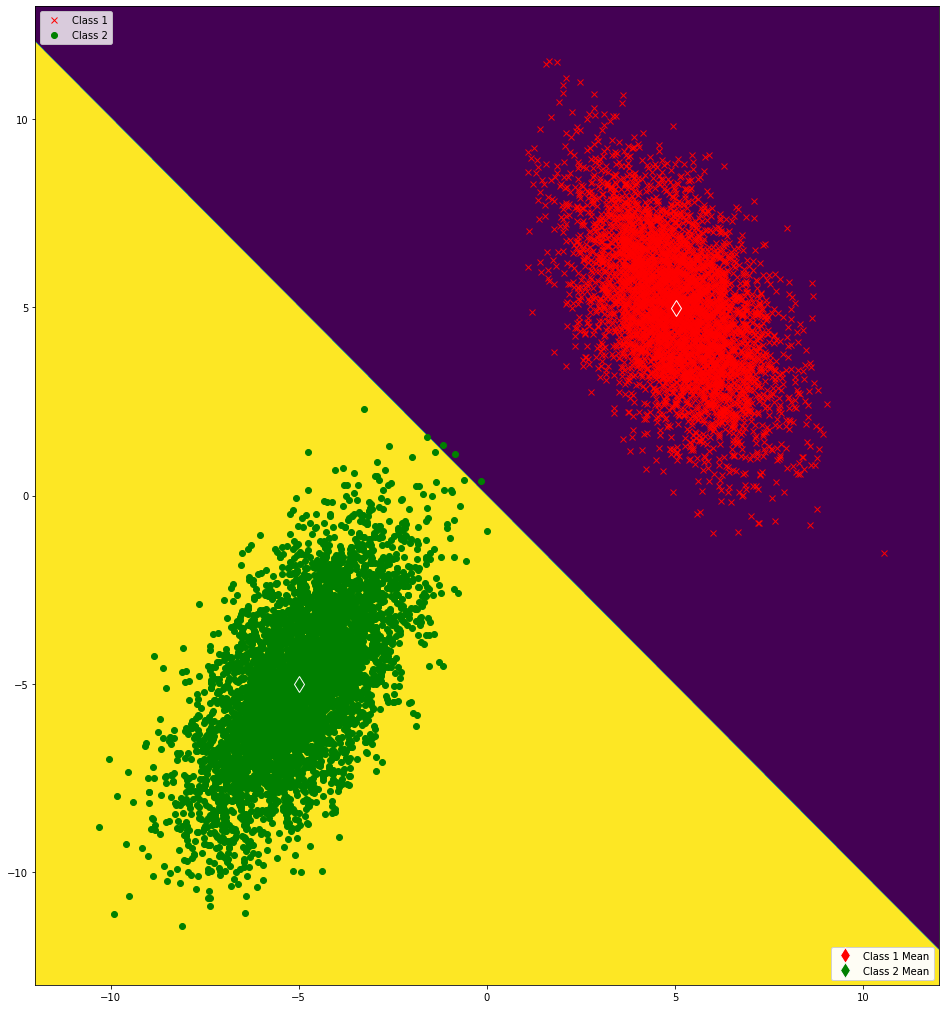

In [79]:
means = np.asarray( [ [5, 5], [-5, -5] ])
lambdas = np.asarray( [ [1, 4], [5, 1] ])  
thetas = np.asarray([ np.pi / 6, np.pi / 3 ])
Ns = np.asarray([5000, 5000])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')
plotDecBoundaries(x, labels, sample_means, fsize=(18,18))

Notice that for the above the data clouds are not symmetric around the sample means.  In this case, it would be better to move the decision boundary to the "northeast" to account for the directional preference.  

Let's try again with an exponential distribution.  Let's not use any rotation or differences in variance.

Data generated under the exponential distribution
The mean in the generating pdf for class 1 is: [5 5]
The sample mean for class 1  data is: [5.02290405 4.9853781 ]

The coloring matrix class 1  data is:
 [[2. 0.]
 [0. 2.]]
The covariance matrix class 1  data is:
 [[4. 0.]
 [0. 4.]]


The mean in the generating pdf for class 2 is: [-5 -5]
The sample mean for class 2  data is: [-5.03075048 -5.0232048 ]

The coloring matrix class 2  data is:
 [[2. 0.]
 [0. 2.]]
The covariance matrix class 2  data is:
 [[4. 0.]
 [0. 4.]]




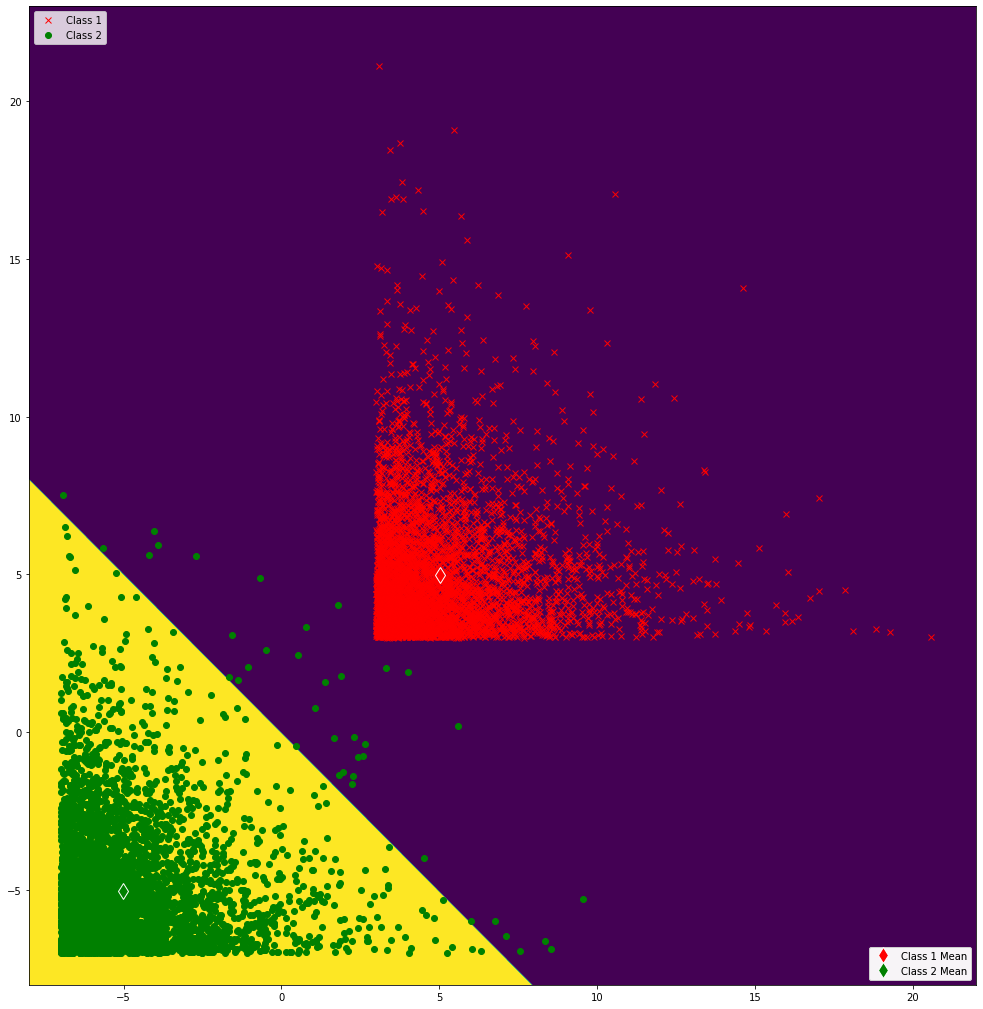

In [80]:
means = np.asarray( [ [5, 5], [-5, -5] ])
lambdas = np.asarray( [ [4, 4], [4, 4] ])  
thetas = np.asarray([ 0, 0 ])
Ns = np.asarray([5000, 5000])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='exponential')
plotDecBoundaries(x, labels, sample_means, fsize=(18,18))

Notice that, again, it would be better to move the decision boundary to the "northeast".  This time, this is because the exponential distribution pdf is not symmetric around the mean.  In fact, the red data is limited in how far to the south and west it can go.  

**Suggestion:** try out some other rotations, means, variances under the different distributions.  

We will return to the problem of deriving a classifier when we know the statistical (probability) model -- in this case, we don't need data to learn/fit the rule, we just use math to derive it!  

**Question:**  The above examples show why data that is not circularly symmetric around the sample mean of each class may cause some issues with the nearest-means classifier.  In the cases above, it appears that a linear classifier is still reasonable, but the decision boundary could be better. Is there a type of data pattern that would render this nearest-means classifier almost useless?

Consider the case when there are two clusters in the data -- e.g., if there is a cluster at $[10, 0]^T$ and $[-10, 0]^T$ for class 1, then the sample mean for class one will be approximately $[0, 0]^T$, but this will be far from both clusters. If the data under class 2 is localized to a single cluster, this creates an example that no linear classifier can effectively solve.  

In the code below, for class 1 data, we add either `means[0]` or `-means[0]` randomly (with probability 1/2 each) to a zero mean version Guassian.  This will create a Guassian mixture distrubution -- i.e., two clouds for class 1.  

In [81]:
def generate_mixed_white_gaussian_data(means, sigmas, Ns):
    N = Ns[0] + Ns[1]
    x = np.zeros((N, 2))
    x[Ns[0]:] = np.random.normal(0, sigmas[1], (Ns[1], 2)) + means[1]

    mixed_mean_0 = np.zeros((Ns[0], 2))
    signs = np.random.choice([-1,1], Ns[0])
    mixed_mean_0.T[0] = signs
    mixed_mean_0.T[1] = signs
    mixed_mean_0 = mixed_mean_0 *  means[0]

    x[:Ns[0]] = np.random.normal(0, sigmas[0], (Ns[0], 2)) + mixed_mean_0

    labels = np.ones(Ns[0] + Ns[1])
    labels[Ns[0]:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:Ns[0]], axis=0)
    sample_means[1] = np.mean(x[Ns[0]:], axis=0)

    return x, labels, sample_means


Let's use this to make clouds at $\pm [10, 0]$ for class 1.  For class 2, we will have one cloud centered at $[2, 0]$

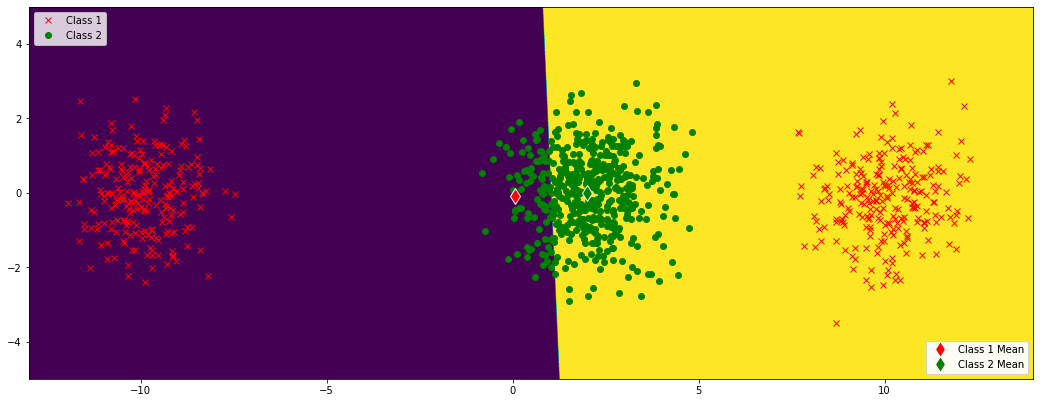

In [82]:
means = np.asarray([ [10,0], [2, 0]])
sigmas = np.asarray([1,1])
Ns = np.asarray([500,500])

x, labels, sample_means = generate_mixed_white_gaussian_data(means, sigmas, Ns)

plotDecBoundaries(x, labels, sample_means, fsize=(18,18))

Notice tha the nearest-means classifier does its job -- the sample mean for class 1 is near $[0, 0]^T$ and the sample mean for class 2 is near $[2, 0]^T$, so the decision boundary is approximately a vertical line at $x_1=1$.  However, half of the data from class 1 is on the wrong side of the decision boundary.  

This is an example of a data set that cannot be well-classified by a linear classifier -- i.e., one cannot draw a single line to split class 1 and class2 data.  

**Question:** What could we do to improve this situation?  

Well, the norm of ${\bf x}$, $\| {\bf x} \|$, is larger for ${\bf x}$ coming from class 1 than it is when ${\bf x}$ is from class 2.  This motivates us to consider using a different feature.  Specifically, let's use the feature $r = \| {\bf x} \|$.  Below, we compute this and show a histogram of this one-dimensional feature under class 1 and class 2.  We also show the sample means and the nearest-means classifier decision boundary for this 1D classifier.  

Sample mean for class 1 = 10.020857034698896
Sample mean for class 2 = 2.2886552377607616
Decision boundary is r = 6.154756136229828


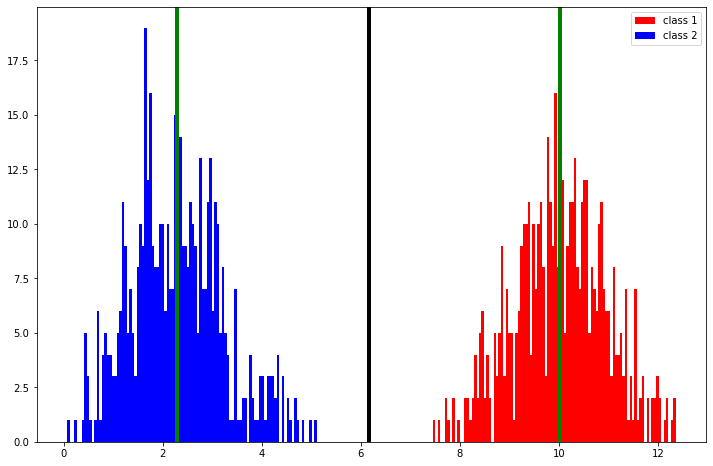

In [91]:
r = np.linalg.norm(x, axis=1)

plt.figure(figsize=(12,8))
N1 = Ns[0]
_ = plt.hist(r[:N1], bins=100, color='r', label='class 1')
_ = plt.hist(r[N1:], bins=100, color='b', label='class 2')
m1 = np.mean(r[:N1])
m2 = np.mean(r[N1:])
boundary = (m1 + m2) / 2
plt.axvline(boundary, linewidth=4, color='k')
plt.axvline(m1, linewidth=4, color='g')
plt.axvline(m2, 0, linewidth=4, color='g')
plt.legend()

print(f'Sample mean for class 1 = {m1}')
print(f'Sample mean for class 2 = {m2}')
print(f'Decision boundary is r = {boundary}')

So, in this example, we satrted with a two-dimensional feature vector for which the classification problem was not well-addressed by a linear classifier.  Through inspection of the data, we _hand-crafted_ a feature that would allow us to use a linear classifier to separate the data.  This hand-creafted feature also reduces the problem from 2 dimensions to 1.  

Finding such hand-crafted features is an art not a science.  This example illustrates the value of inspecting and visualizing your data.  It also shows how feature selection/design can affect the type of classifier required.  In this example, our conversion from ${\bf x}$ to $r = \| {\bf x} \|$ reduced the problem to one dimension and allowed a simple nearest-means (linear) classifier to work very well.

**Suggestion:** try playing with the variance of the clouds in this example and see how this impacts the histogram above.